In [1]:
import os
import csv
import numpy as np
import time

import pandas as pd

output_folder = '../data/processed'
output_file = 'uspto.csv'

partitions = [10000, 25000, 50000, 100000, 250000, 500000, 1000000, 2000000]


In [ ]:
# Read the first 5 lines of the CSV file
df_full = pd.read_csv(os.path.join(output_folder, output_file), delimiter='\t')
for p in partitions:
    file_name = f'uspto_{p}.csv'
    print(file_name)
    if p < 500000:
        print('under',p)
        df_p = df_full.sample(n=p)        
    else:
        print('above',p)
        n = int(np.ceil(p/len(df_full)))
        df_p = pd.concat([df_full]*n, ignore_index=True).iloc[:p]
        
    df_p.to_csv(os.path.join(output_folder, file_name), sep='\t', lineterminator='\n',index=False, quoting = csv.QUOTE_NONE)

In [2]:
from noctis.data_transformation.preprocessing.data_preprocessing import Preprocessor, PreprocessorConfig


In [3]:
preprocess_config = PreprocessorConfig(output_folder='../output_performance', tmp_folder='../output_performance/tmp',
                                       inp_chem_format='smiles', out_chem_format='smiles', validation=False,
                                       parallel=True, prefix='USPTO', blocksize=600000, chunksize=100, delimiter='\t',delete_tmp = True,lineterminator=None)

In [4]:
preprocessor = Preprocessor()

In [ ]:
times = []
for p in partitions:
    if p > 0:
        inp_file = f'../data/processed/uspto_{p}.csv'
        start_time = time.perf_counter()
        preprocessor.preprocess_csv_for_neo4j(input_file=inp_file, config = preprocess_config)
        end_time = time.perf_counter()
        elapsed_time=end_time-start_time
        times.append(elapsed_time)
        print(f'{p} {elapsed_time:.4f}')
              

In [6]:
from matplotlib import pyplot as plt
import pandas as pd

In [7]:

df = pd.read_csv('../data/for_figures/performance.csv')

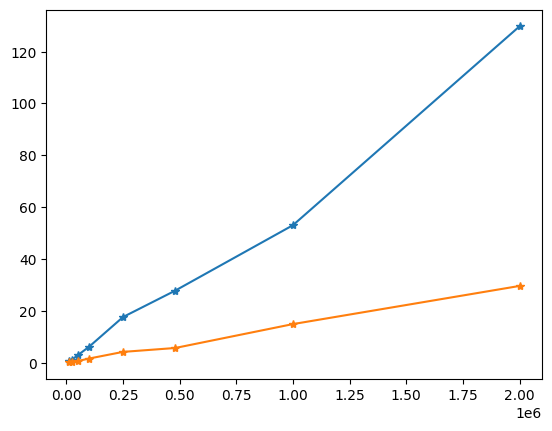

In [9]:
x = df['size[rows]']
y = df['time_v[sec]']/60
yy = df['time_nv[sec]']/60
plt.plot(x,y,'*-')
plt.plot(x,yy,'*-')

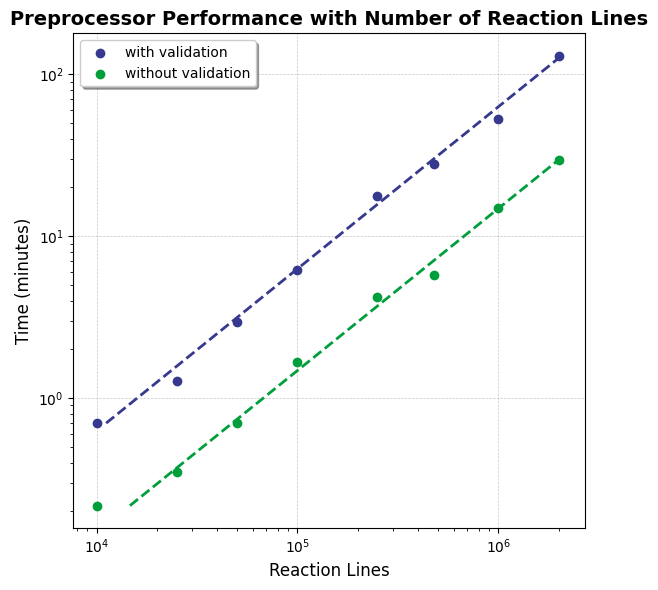

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Set a seed for reproducibility
np.random.seed(0)


color_data1 = '#36398E'  # green
color_data2 = '#009F3C'   # blue
color_fit1 = '#36398E' # yellow
color_fit2 = '#009F3C'   # gray

# Fit lines through the origin.
# For a line forced through the origin (x = a * y), the optimal coefficient is:
# a = sum(x*y) / sum(y^2)
a1 = np.sum(x * y) / np.sum(y**2)
a2 = np.sum(x * yy) / np.sum(yy**2)

# Prepare fitted lines for a smooth plot.
# For data series 1, create a range of y3 values and compute the corresponding x values using x = a1*y3.
y3_fit = np.logspace(np.log10(np.min(y)), np.log10(np.max(y)), 100)
x_fit1 = a1 * y3_fit

# Similarly, for data series 2:
y2_fit = np.logspace(np.log10(np.min(yy)), np.log10(np.max(yy)), 100)
x_fit2 = a2 * y2_fit

# Create the plot with aspect ratio 1:1
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xscale('log')
ax.set_yscale('log')

# Plot original data as scatter plots.
ax.scatter(x, y, color=color_data1, label='with validation', zorder=3)
ax.scatter(x, yy, color=color_data2, label='without validation', zorder=3)

# Plot the fitted lines using dashed styles.
ax.plot(x_fit1, y3_fit, color=color_fit1, linestyle='--', linewidth=2)
ax.plot(x_fit2, y2_fit, color=color_fit2, linestyle='--', linewidth=2)

# Enhance the plot with axis labels, title, grid, and legend.
ax.set_xlabel('Reaction Lines', fontsize=12)
ax.set_ylabel('Time (minutes)', fontsize=12)
ax.set_title('Preprocessor Performance with Number of Reaction Lines', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(frameon=True, shadow=True, fontsize=10)

# Set aspect ratio to 1:1
# ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('./Fig4_performance.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()